In [12]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/Users/lenasalzmann/dev/dbs-eeg-sync/notebooks/source', '/Users/lenasalzmann/dev/dbs-eeg-sync', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages']


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from source.data_loader import load_eeg_data, open_json_file, read_time_domain_data

from source.sync_artefact_finder import find_dbs_peak

In [14]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011', 'P4-2012']

block = 'pre8walk'

dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"


In [15]:
file_info = [
    {"sub_id": "P4-2001", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json"},
    {"sub_id": "P4-2002", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json"},
    {"sub_id": "P4-2003", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json"},
    {"sub_id": "P4-2004", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json"},
    {"sub_id": "P4-2005", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json"},
    {"sub_id": "P4-2007", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json"},
    {"sub_id": "P4-2008", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json"},
    {"sub_id": "P4-2009", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json"},
    {"sub_id": "P4-2010", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json"},
    {"sub_id": "P4-2011", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2011/RawData/DBS/Report_Json_Session_Report_20250520T165018.json"},
    {"sub_id": "P4-2012", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2012/RawData/DBS/Report_Json_Session_Report_20250710T122046.json"},

]

Processing P4-2001 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 508.5
...length of dbs signal in samples: 127125


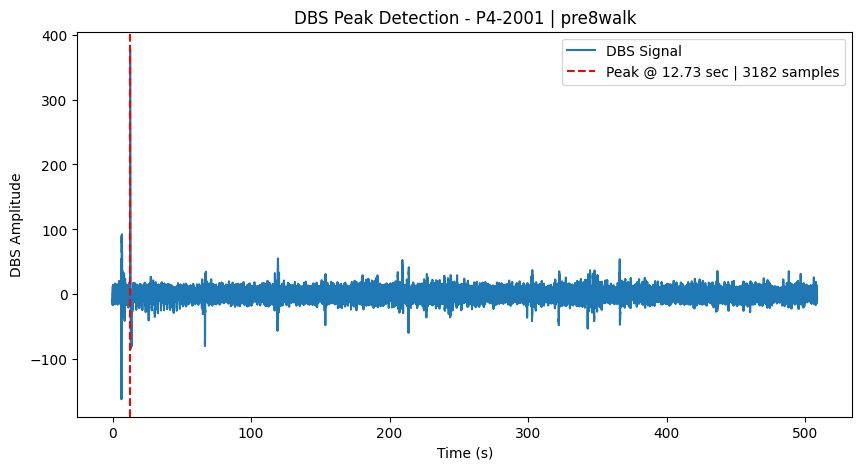

Processing P4-2002 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 304.5
...length of dbs signal in samples: 76125


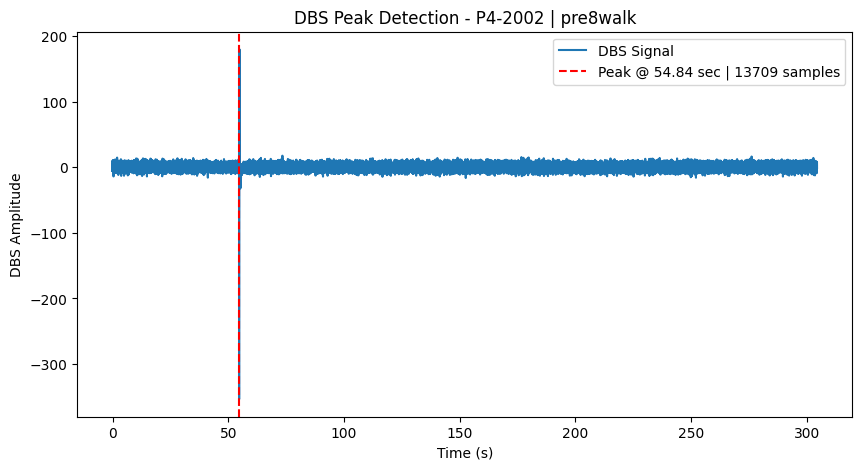

Processing P4-2003 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 156.5
...length of dbs signal in samples: 39125


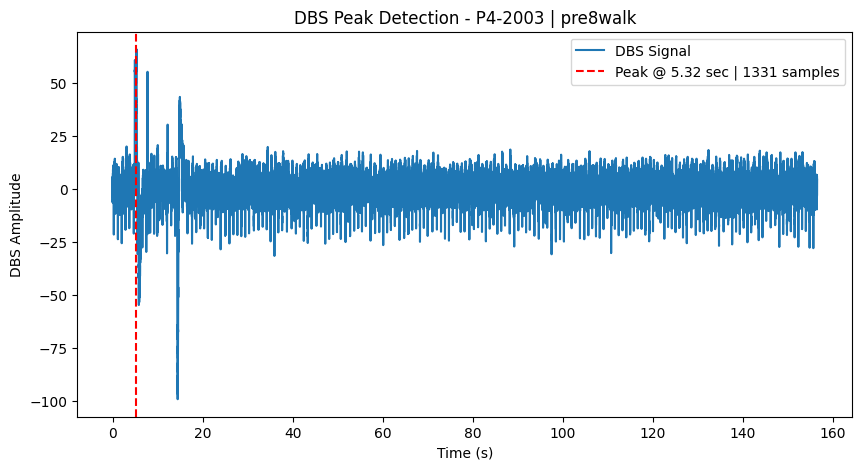

Processing P4-2004 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 160.0
...length of dbs signal in samples: 40000


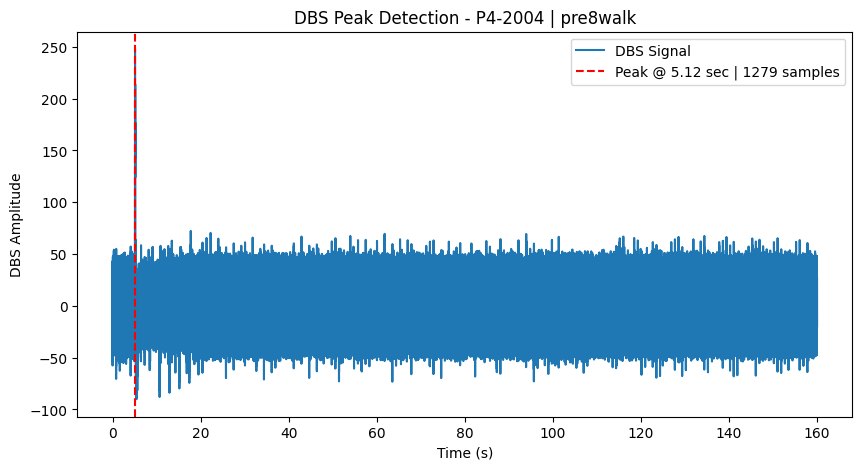

Processing P4-2005 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 107.5
...length of dbs signal in samples: 26875


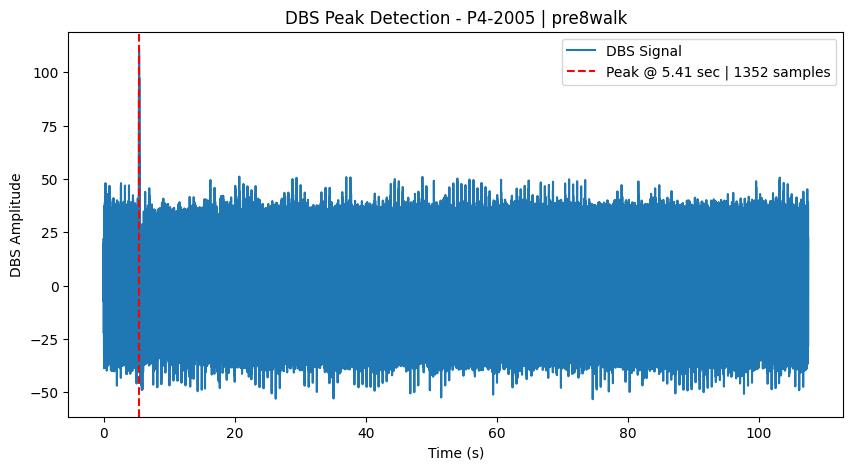

Processing P4-2007 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 153.0
...length of dbs signal in samples: 38250


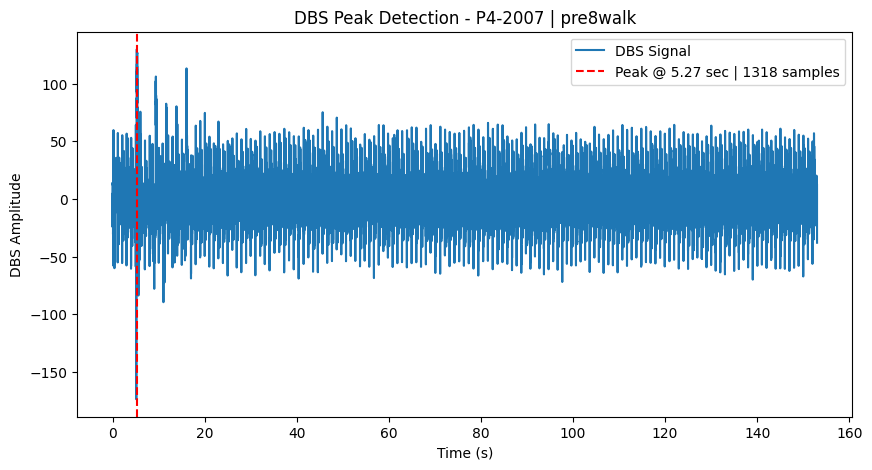

Processing P4-2008 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 103.0
...length of dbs signal in samples: 25750


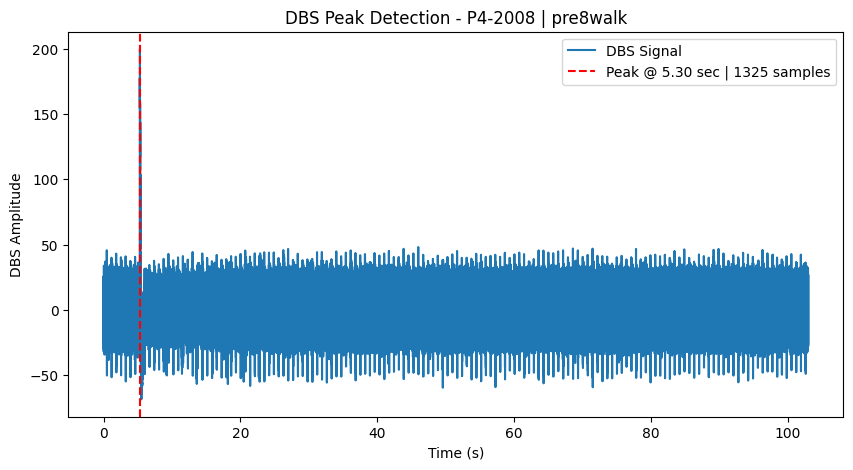

Processing P4-2009 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 106.5
...length of dbs signal in samples: 26625


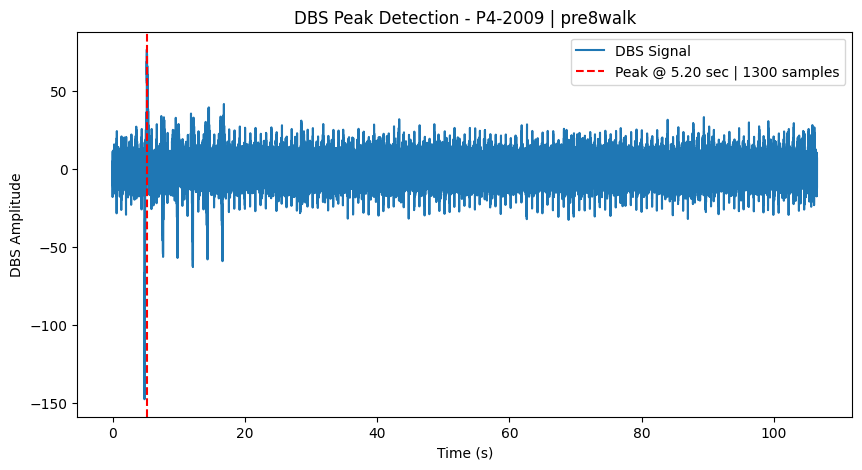

Processing P4-2010 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 155.5
...length of dbs signal in samples: 38875


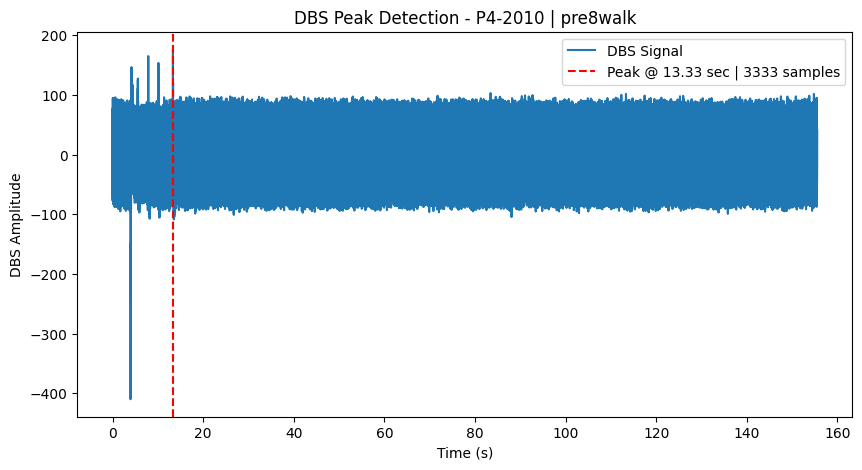

Processing P4-2011 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2011/RawData/DBS/Report_Json_Session_Report_20250520T165018.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 154.5
...length of dbs signal in samples: 38625


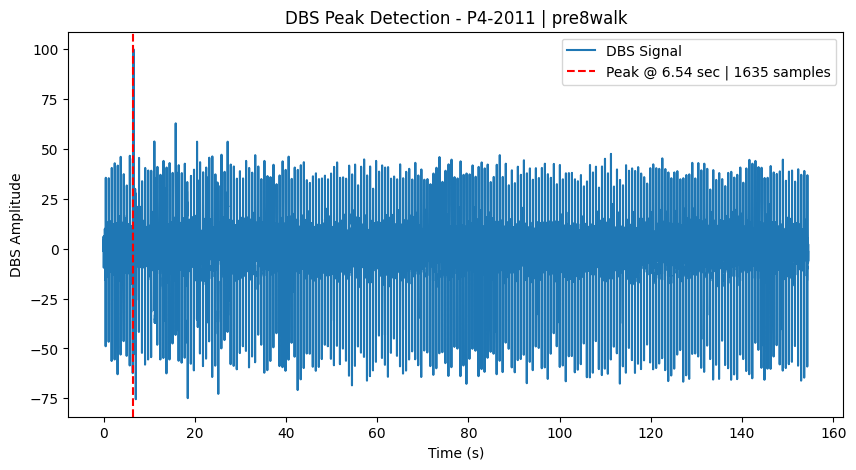

Processing P4-2012 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2012/RawData/DBS/Report_Json_Session_Report_20250710T122046.json
---
Successfully read DBS recording 3 with sampling frequency 250 Hz
...length of dbs signal in seconds: 153.0
...length of dbs signal in samples: 38250


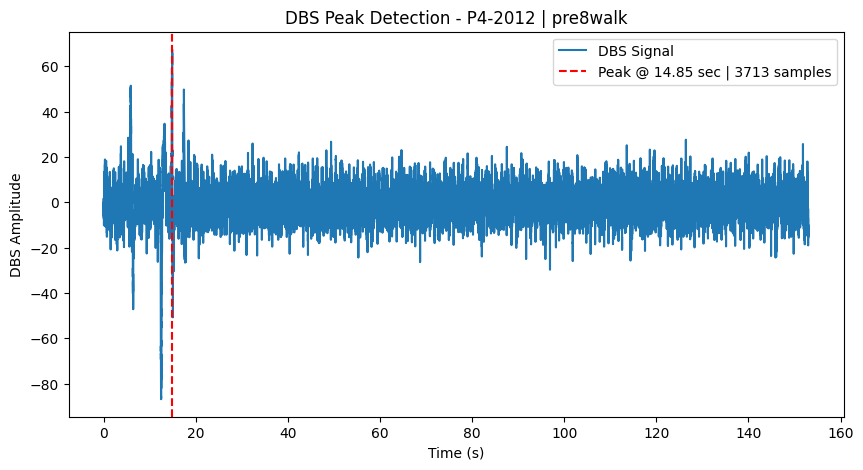

In [18]:
for file in file_info:
    sub_id = file["sub_id"]
    dbs_path = file["file_path"]
    print(f"Processing {sub_id} from {dbs_path}")
    # Load DBS
    json_data = open_json_file(dbs_path)
    # block_num = select_recording(json_data)
    block_num = 3  # Assuming you want to process the first block
    dbs_data = read_time_domain_data(json_data, block_num)

    # Find DBS peak
    dbs_signal =  dbs_data["TimeDomainData"].values
    dbs_fs = dbs_data["SampleRateInHz"][0]
    dbs_peak_idx, dbs_peak_time = find_dbs_peak(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)

    # Compute time axis
    dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs
